# **Import Modules**

In [ ]:
!pip install split-folders -q

In [ ]:
import kagglehub
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import splitfolders

from PIL import Image
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks, optimizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV3Large
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from pathlib import Path

# **Download Data**

In [ ]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

main_data_path = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification"

# **Split Dataset**

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isdir(path):
            for img_filename in os.listdir(path):
                img_path = os.path.join(path, img_filename)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    images.append(np.array(img))
                    labels.append(filename)
                except Exception as e:
                    print(f"Error loading image: {img_path}, {e}")
    return images, labels

In [ ]:
def plot_label_distribution(labels, title):
    label_counts = pd.Series(labels).value_counts()
    total_counts = label_counts.sum()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(f"{title} - Total {total_counts} Images")
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

In [ ]:
splitfolders.ratio(main_data_path, output="/content/dataset", seed=1337, ratio=(.8, .1, .1))

Copying files: 2527 files [00:07, 341.50 files/s]


In [ ]:
TRAIN_PATH = '/content/dataset/train'
VAL_PATH = '/content/dataset/val'
TEST_PATH = '/content/dataset/test'

In [ ]:
img_train, labels_train = load_images_from_folder(TRAIN_PATH)
img_val, labels_val = load_images_from_folder(VAL_PATH)
img_test, labels_test = load_images_from_folder(TEST_PATH)

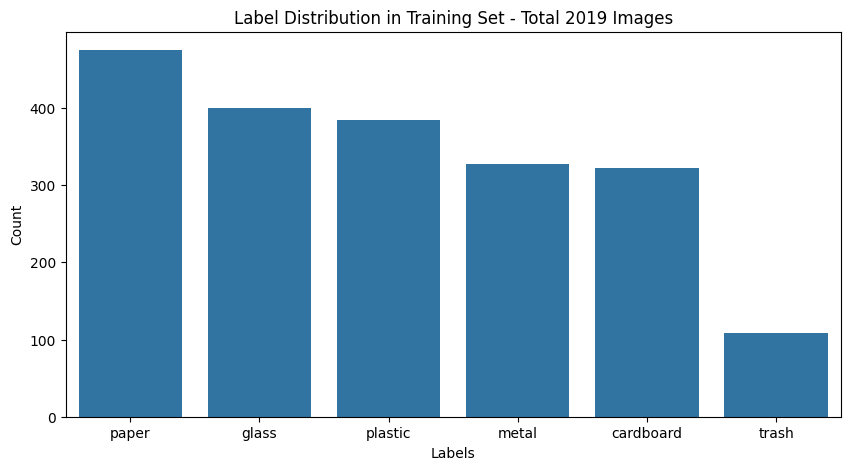

In [ ]:
plot_label_distribution(labels_train, 'Label Distribution in Training Set')

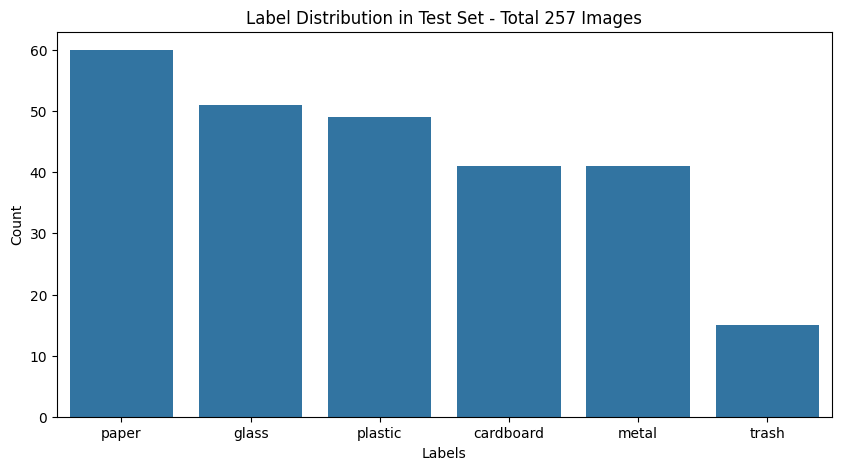

In [ ]:
plot_label_distribution(labels_test, 'Label Distribution in Test Set')

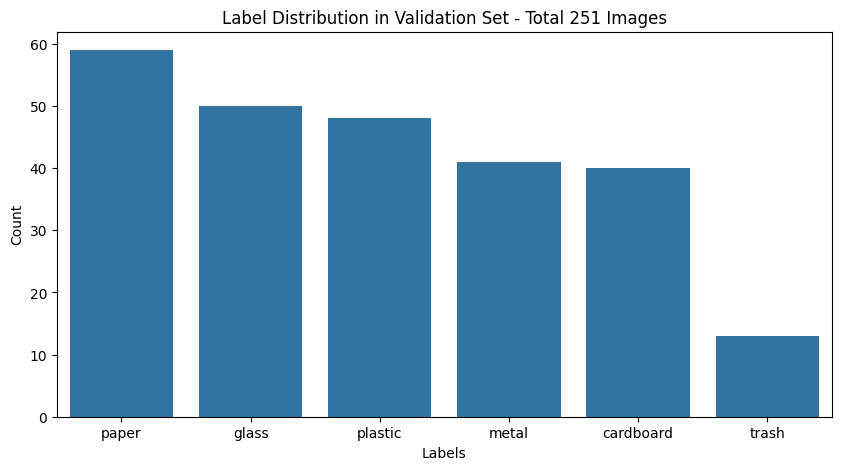

In [ ]:
plot_label_distribution(labels_val, 'Label Distribution in Validation Set')

# **Create Dataset**

In [ ]:
def create_datasets(base_dir, image_size=(224,224),batch_size=32):
    """Create training, validation, and test datasets from pre-split folders"""
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    train_ds = keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='categorical'
    )

    val_ds = keras.utils.image_dataset_from_directory(
        val_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='categorical'
    )

    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=False
    )

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds , val_ds, test_ds = create_datasets('/content/dataset')

Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.


# **Data Augmentation & Preprocessing**

In [ ]:
def create_data_augmentation():
    return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.1),
        ], name="data_augmentation")

In [ ]:
def create_preprocessing(cat):
    if cat == "ResnetV2":

      return keras.Sequential([
            layers.Rescaling(scale=1./127.5, offset=-1)
        ], name="preprocessing")

    else:

      return keras.Sequential([
            layers.Rescaling(1./255),
            layers.Normalization(mean=[0.485, 0.456, 0.406],
                               variance=[0.229**2, 0.224**2, 0.225**2])
        ])

# **Modeling**

In [ ]:
def callbacks_build(model_name):
    callbacks_list = [
            callbacks.ModelCheckpoint(
                filepath=f"/content/models/{model_name}.weights.h5",
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=True,
                mode='max',
                verbose=1
            ),

            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),

            callbacks.TensorBoard(
                log_dir='./logs',
                histogram_freq=1,
                write_graph=True,
                write_images=True
            ),

            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3
            )
      ]

    return callbacks_list

In [ ]:
def get_optimizer(initial_lr=1e-3):
    return tf.keras.optimizers.Adam(learning_rate=initial_lr)


def get_loss(label_smoothing=0.1):
    return tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=label_smoothing,
        from_logits=False
    )

def compile_model(model, optimizer, loss, metrics=['accuracy', 'top_k_categorical_accuracy']):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    return model

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

## Resnet50

In [ ]:
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = create_data_augmentation()(inputs)
    x = create_preprocessing("ResnetV2")(x)
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = keras.Model(inputs, outputs)

    l2_strength = 1e-3
    for layer in model.layers:
        if isinstance(layer, layers.Dense):
            layer.kernel_regularizer = l2(l2_strength)

    return model

In [ ]:
resnet_model = build_resnet_model((224, 224, 3), 6)

class_counts = [322, 400, 328, 475, 385, 109]
total_samples = sum(class_counts)
class_weights = {
    i: total_samples / (len(class_counts) * count)
    for i, count in enumerate(class_counts)
}

optimizer = get_optimizer(1e-4)

resnet_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)

In [ ]:
resnet_callbacks = callbacks_build('resnet_model')
history_phase1 = resnet_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=resnet_callbacks
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.1825 - loss: 2.4183
Epoch 1: val_accuracy improved from -inf to 0.37052, saving model to /content/models/resnet_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 343ms/step - accuracy: 0.1831 - loss: 2.4165 - val_accuracy: 0.3705 - val_loss: 1.6374
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2719 - loss: 2.0408
Epoch 2: val_accuracy improved from 0.37052 to 0.49004, saving model to /content/models/resnet_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy: 0.2722 - loss: 2.0389 - val_accuracy: 0.4900 - val_loss: 1.3624
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3790 - loss: 1.6913
Epoch 3: val_accuracy improved from 0.49004 to 0.56972, saving model to /content/models/resnet_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - accuracy: 0.3791 - loss: 1.6909 - val_accuracy: 0.5697 - val_loss: 1.2074
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

# **Evaluation**

In [ ]:
!pip freeze > requirements.txt